In [1]:
import pandas as pd
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
class IEMOCAPDataset(Dataset):
    
    def __init__(self, data_dir='', csv_fname='labels.csv', spectrogram_dir='spectrogram_v1', train=True, transform=None):

        self.df = pd.read_csv(f'{data_dir}/{csv_fname}')
        self.data_dir = data_dir
        self.spectrogram_dir = spectrogram_dir
        self.transform = transform

        # remove extra labels
        for l in ['xxx', 'fru', 'sur', 'fea', 'oth', 'dis']:
            self.df = self.df[self.df.emotion_label != l]
        self.df.loc[self.df.emotion_label == 'exc', 'emotion_label'] = 'hap' # combine happy and excited labels
        
        # train/test split
        if train:
            self.df = self.df[self.df.file_id < 'Ses05']
        else:
            self.df = self.df[self.df.file_id > 'Ses05']

        self.df = self.df.reset_index(drop=True)

        self.label_map = {
            'hap': 0,
            'sad': 1,
            'ang': 2,
            'neu': 3,
        }

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_id = self.df['file_id'][idx]
        image = io.imread(f'{self.data_dir}/{self.spectrogram_dir}/{file_id}.png')
        image = image[:,:,0:3] # remove alpha channel
        print(image.shape)
        label = self.label_map[self.df['emotion_label'][idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# create datasets and dataloaders
data_dir = '/mnt/efs/fs1/18-781-Project/emotion/data/iemocap'

trainset = IEMOCAPDataset(
    data_dir=data_dir,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

testset = IEMOCAPDataset(
    data_dir=data_dir,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

trainloader = DataLoader(
    trainset,
    batch_size = 8,
    shuffle = True
)

testloader = DataLoader(
    testset,
    batch_size = 8,
    shuffle = True
)

train length 4290
test length 1241
loading image batch...
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
batch shape torch.Size([8, 3, 224, 224])
label 3


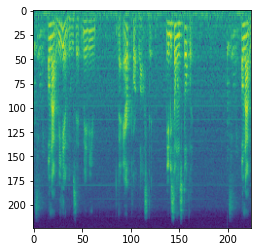

In [4]:
# test dataloaders
import matplotlib.pyplot as plt

print('train length', len(trainset))
print('test length', len(testset))

print('loading image batch...')
for images, labels in trainloader:
    print('batch shape', images.shape)
    print('label', labels[0].item())
    plt.imshow(images[0].permute(1, 2, 0))
    break